In [1]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
UNK = 0
PAD = 1

from core.datasets.datasets import *
from core.datasets.sim import *           # inc_tmm 在这里
from core.models.transformer import *
from core.trains.train import *

# ================= 0) 光谱网格：380–750 nm，步长 5 nm =================
def make_wavelengths():
    return np.arange(380.0, 750.0 + 1e-9, 5.0)  # nm

# ================= 1) 折射率表 =================
lam_tab_tio2 = np.array([380.0,425.0,450.0,475.0,500.0,525.0,550.0,575.0,600.0,
                         625.0,650.0,675.0,750.0,775.0,800.0,825.0,850.0,900.0,
                         1000.0,1060.0])
n_tab_tio2   = np.array([2.55,2.49,2.469,2.444,2.422,2.402,2.385,2.37,2.351,
                         2.343,2.337,2.331,2.322,2.317,2.313,2.311,2.309,2.305,
                         2.300,2.299])
def n_tio2(lam_nm): return np.interp(lam_nm, lam_tab_tio2, n_tab_tio2)

lam_tab_sio2 = np.array([300.0,350.0,400.0,450.0,500.0,550.0,600.0,650.0,700.0,900.0,1000.0])
n_tab_sio2   = np.array([1.478 ,1.472 ,1.467 ,1.463 ,1.459 ,1.455 ,1.452 ,1.450 ,1.446 ,1.437 ,1.434])
def n_sio2(lam_nm): return np.interp(lam_nm, lam_tab_sio2, n_tab_sio2)

lam_tab_mgf2 = np.array([248.0, 550.0, 1550.0])
n_tab_mgf2   = np.array([1.40 , 1.38 , 1.36  ])
def n_mgf2(lam_nm): return np.interp(lam_nm, lam_tab_mgf2, n_tab_mgf2)

glass_n_const = 1.5163
def n_glass(lam_nm): return np.full_like(lam_nm, glass_n_const, dtype=float)

# ================= 2) 网格与 nk_dict =================
lam_nm = make_wavelengths()                # nm
wavelengths = lam_nm / 1e3                 # µm
nk_dict = {
    'TiO2': n_tio2(lam_nm).astype(np.complex128),
    'SiO2': n_sio2(lam_nm).astype(np.complex128),
    'MgF2': n_mgf2(lam_nm).astype(np.complex128),
    'Glass_Substrate': n_glass(lam_nm).astype(np.complex128),
}

# ================= 3) TMM 包装：返回 [R..., T...] =================
def spectrum(materials, thickness, pol='s', theta=0, wavelengths=None,
             nk_dict=None, substrate='Glass_Substrate', substrate_thick=500000):
    assert len(materials) == len(thickness)
    assert nk_dict is not None and wavelengths is not None
    assert pol in ('s','p','u')

    theta_rad = theta * (math.pi / 180.0)
    wavess = (1e3 * np.asarray(wavelengths)).astype(int)

    thickness_full = [np.inf] + list(thickness) + [substrate_thick, np.inf]
    inc_list = ['i'] + ['c'] * len(materials) + ['i', 'i']

    R, T = [], []
    def _rt(pol_char, n_list, d_list, inc_list, theta_in, lambda_vac):
        res = inc_tmm(pol_char, n_list, d_list, inc_list, theta_in, lambda_vac)
        return res['R'], res['T']

    for i, lambda_vac in enumerate(wavess):
        n_list = [1.0] + [nk_dict[m][i] for m in materials] + [nk_dict[substrate][i], 1.0]
        if pol == 'u':
            rs, ts = _rt('s', n_list, thickness_full, inc_list, theta_rad, lambda_vac)
            rp, tp = _rt('p', n_list, thickness_full, inc_list, theta_rad, lambda_vac)
            r, t = 0.5*(rs+rp), 0.5*(ts+tp)
        else:
            r, t = _rt(pol, n_list, thickness_full, inc_list, theta_rad, lambda_vac)
        R.append(float(r)); T.append(float(t))
    return R + T

# # ================= 4) Matplotlib 样式 =================
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 120
# mpl.rcParams['figure.figsize'] = (6, 4)
# mpl.rcParams.update({'font.size': 15, 'axes.titlesize': 15, 'axes.labelsize': 15, 'axes.titlepad': 10})

# import matplotlib.font_manager as fm
# try:
#     fm.fontManager.addfont('/usr/share/fonts/truetype/msttcorefonts/arial.ttf')
#     plt.rcParams['font.family'] = 'Arial'
# except Exception:
#     pass

# ================= 5) 加载模型（只做推理） =================
a = torch.load('/home/sysadmin/WorkSpace/PXY/optogpt/optogpt/saved_models/optogpt/test/model_inverse_R_T_S_R_B_LR_WU_L_H_D_F_[2, 0.1, 512, 0.0003, 1200, 6, 8, 512, 2048]_best1030.pt')
args = a['configs']
torch.manual_seed(args.seeds); np.random.seed(args.seeds)

model = make_model_I(args.spec_dim, args.struc_dim, args.layers, args.d_model, args.d_ff, args.head_num, args.dropout).to(DEVICE)
model.load_state_dict(a['model_state_dict'])
criterion = LabelSmoothing(args.struc_dim, padding_idx=0, smoothing=args.smoothing)
count_params(model)

# 仅为拿词典与分批工具：不必真的加载/覆盖训练数据
TRAIN_FILE = './dataset/Structure_train.pkl'
TRAIN_SPEC_FILE = './dataset/Spectrum_train.pkl'
DEV_FILE = './dataset/Structure_dev.pkl'
DEV_SPEC_FILE = './dataset/Spectrum_dev.pkl'
data = PrepareData(TRAIN_FILE, TRAIN_SPEC_FILE, args.ratios, DEV_FILE, DEV_SPEC_FILE, args.batch_size, 'R_T', 'Inverse')
data.struc_word_dict, data.struc_index_dict = a['configs'].struc_word_dict, a['configs'].struc_index_dict

# ================= 6) 工具函数：解析/评估 =================
SPECIAL = {"BOS","EOS","PAD","UNK", None, ""}
# 清洗 token 序列：丢弃 BOS/PAD/UNK，遇到 EOS 截断
def clean_tokens(tokens):
    out = []
    for tok in tokens:
        if tok in SPECIAL:
            if tok == "EOS": break
            continue
        out.append(tok)
    print("clean_tokens →", out)  # 打印，可注释
    return out
# 将 token 序列解析为 (materials, thicknesses)，最多保留 max_layers 层
def return_mat_thick(tokens, max_layers=20):
    tokens = clean_tokens(tokens)[:max_layers]  # ≤20层软裁剪
    mats, thks = [], []
    for tok in tokens:
        s = str(tok)
        if "_" not in s:
            if mats and s.replace(".","",1).isdigit():
                mats.append(mats[-1]); thks.append(float(s))
            continue
         
        mat, thk = s.split("_", 1)
        num = "".join(ch for ch in thk if ch.isdigit() or ch==".")
        if not num: continue
        thks.append(float(num)); mats.append(mat)
    return mats, thks
# 辅助判断“是否为一维向量”，可选校验长度 n
def _is_vector(x, n=None):
    try: arr = np.asarray(x).squeeze()
    except Exception: return False
    if arr.ndim != 1: return False
    return (n is None) or (arr.size == n)
# 从多种返回格式里“稳健”取出 (R, T)，必要时从拼接向量中拆分；失败则报错
def extract_RT(spec_obj, wavelengths_len: int):
    if isinstance(spec_obj, (list, tuple)):
        if len(spec_obj) >= 2 and all(_is_vector(v) for v in spec_obj[:2]):
            return np.asarray(spec_obj[0]).squeeze(), np.asarray(spec_obj[1]).squeeze()
    if isinstance(spec_obj, dict):
        keys = {str(k).lower(): k for k in spec_obj.keys()}
        if "r" in keys and "t" in keys:
            return np.asarray(spec_obj[keys["r"]]).squeeze(), np.asarray(spec_obj[keys["t"]]).squeeze()
        r_key = next((k for k in spec_obj if str(k).lower().startswith("r")), None)
        t_key = next((k for k in spec_obj if str(k).lower().startswith("t")), None)
        if r_key is not None and t_key is not None:
            return np.asarray(spec_obj[r_key]).squeeze(), np.asarray(spec_obj[t_key]).squeeze()
    for attr_r in ("R","r"):
        for attr_t in ("T","t"):
            if hasattr(spec_obj, attr_r) and hasattr(spec_obj, attr_t):
                return np.asarray(getattr(spec_obj, attr_r)).squeeze(), np.asarray(getattr(spec_obj, attr_t)).squeeze()
    arr = np.asarray(spec_obj).squeeze()
    wl = wavelengths_len
    if arr.ndim == 1 and arr.size == 2 * wl:
        first, second = arr[:wl], arr[wl:]
        if np.all((first>=0)&(first<=1)) and np.all((second>=0)&(second<=1)):
            return first, second
        return second, first
    raise ValueError("extract_RT: 无法解析 (R,T)。")
# 将 R/T 两段同长向量拼接为单个特征向量 [R..., T...]
def assemble_spec_vector(R, T):
    R = np.asarray(R, dtype=np.float32).reshape(-1)
    T = np.asarray(T, dtype=np.float32).reshape(-1)
    assert R.shape == T.shape, f"R/T 长度不一致: {R.shape} vs {T.shape}"
    return np.concatenate([R, T], axis=0)
# 功能：加权 MAE（默认普通 MAE）；w 是逐元素权重向量
def weighted_mae(y_true, y_pred, w=None):
    a = np.asarray(y_true, dtype=np.float64)
    b = np.asarray(y_pred, dtype=np.float64)
    if w is None: return float(np.mean(np.abs(a-b)))
    w = np.asarray(w, dtype=np.float64)
    return float(np.sum(np.abs(a-b)*w) / (np.sum(w)+1e-12))
# 将通道,波长,值[,权重]文本解析为与 wavelengths_nm 对齐的 R_target / T_target（支持百分数写法）
def parse_user_targets(directives_text: str, wavelengths_nm, 
                       default_R: float = 0.0, default_T: float = 0.0,
                       clip01: bool = True):
    """
    将用户的锚点文本（每行: 通道, 波长(nm), 值[, 权重]）解析为与 wavelengths_nm 对齐的 (R_target, T_target) 数组。
    规则：
      - 同一通道给出 >=2 个点：对该通道做分段线性插值；区间外用端点值外延（hold）。
      - 只给 1 个点：整段常数。
      - 未给点：用默认值（default_R / default_T）。
    说明：
      - 文本里的第4列“权重”仅用于权重构造函数，这里忽略。
      - 值默认为 0~1，小数或百分数都支持（>1 视为百分比并自动 /100）。
    """
    wl = np.asarray(wavelengths_nm, dtype=float).reshape(-1)
    N = wl.size

    # 收集锚点
    pts = {"R": [], "T": []}
    lines = [ln.strip() for ln in str(directives_text).strip().splitlines() if ln.strip()]
    for raw in lines:
        parts = [p.strip() for p in raw.split(',')]
        if len(parts) < 3:
            raise ValueError(f"格式错误: {raw}，应为 通道, 波长, 值[, 权重]")
        ch = parts[0].upper()
        if ch not in ("R", "T"):
            raise ValueError(f"未知通道: {ch}（只支持 R/T）")
        lam = float(parts[1])
        val = float(parts[2])
        # 支持百分比写法：>1 视为百分数
        if val > 1.0: 
            val = val / 100.0
        pts[ch].append((lam, val))

    def build_channel(target_points, default_val):
        if len(target_points) == 0:
            arr = np.full(N, float(default_val), dtype=np.float32)
        elif len(target_points) == 1:
            v = float(target_points[0][1])
            arr = np.full(N, v, dtype=np.float32)
        else:
            # 对该通道做分段线性插值，并在边界外延
            target_points = sorted(target_points, key=lambda x: x[0])
            xs = np.array([p[0] for p in target_points], dtype=float)
            ys = np.array([p[1] for p in target_points], dtype=float)
            arr = np.interp(wl, xs, ys, left=ys[0], right=ys[-1]).astype(np.float32)
        if clip01:
            np.clip(arr, 0.0, 1.0, out=arr)
        return arr

    R = build_channel(pts["R"], default_R)
    T = build_channel(pts["T"], default_T)
    return R, T

# === 权重：默认只在指定点计分（其他点=0） ===
# 仅在指定波长点处赋权（其余为 base，默认 0），拼接成 [wR..., wT...]
def build_spec_weights_from_points(wavelengths_nm, directives_text, base=0.0):
    wl = np.asarray(wavelengths_nm, dtype=float).reshape(-1)  # nm
    N = wl.size
    wR = np.full(N, base, dtype=np.float32)
    wT = np.full(N, base, dtype=np.float32)
    lines = [ln.strip() for ln in directives_text.strip().splitlines() if ln.strip()]
    for raw in lines:
        parts = [p.strip() for p in raw.split(',')]
        if len(parts) < 4:
            raise ValueError(f"格式错误: {raw}，应为 通道, 波长, 值, 权重")
        ch, lam, _val, alpha = parts[0].upper(), float(parts[1]), float(parts[2]), float(parts[3])
        idx = int(np.argmin(np.abs(wl - lam)))
        if ch == "R": wR[idx] = float(alpha)
        elif ch == "T": wT[idx] = float(alpha)
        else: raise ValueError(f"未知通道 {ch}")
    return np.concatenate([wR, wT], axis=0)

# （可选）高斯带宽版：把单点权重扩成邻域，bring me shiiiiiiiiit 
# 在指定点附近按高斯展开权重（σ=sigma_nm），再拼接 [wR..., wT...]
def build_spec_weights_from_points_gaussian(wavelengths_nm, directives_text, sigma_nm=15.0, base=0.0):
    wl = np.asarray(wavelengths_nm, dtype=float).reshape(-1)
    N = wl.size
    wR = np.full(N, base, dtype=np.float32)
    wT = np.full(N, base, dtype=np.float32)
    lines = [ln.strip() for ln in directives_text.strip().splitlines() if ln.strip()]
    for raw in lines:
        parts = [p.strip() for p in raw.split(',')]
        if len(parts) < 4:
            raise ValueError(f"格式错误: {raw}")
        ch, lam, _val, alpha = parts[0].upper(), float(parts[1]), float(parts[2]), float(parts[3])
        g = np.exp(-0.5 * ((wl - lam)/sigma_nm)**2)
        g = g / (g.max() + 1e-12) * float(alpha)
        if ch == "R": wR = np.maximum(wR, g.astype(np.float32))
        elif ch == "T": wT = np.maximum(wT, g.astype(np.float32))
        else: raise ValueError(f"未知通道 {ch}")
    return np.concatenate([wR, wT], axis=0)

# ================= 7) 解码辅助：约束与抽样 =================
# 按已输出层数对下一个 token 的概率分布做规则屏蔽（禁止 BOS；超层数仅允许 EOS）
def mask_invalid_next(probs, word_dict, step_layers, max_layers=20):
    """
    probs: Tensor [1, vocab] 或 [vocab] 的概率分布（不是log）
    step_layers: 当前已输出的“结构”层数（不含BOS/EOS）
    规则：
      - 若 step_layers >= max_layers：只保留 EOS
      - 否则：禁止 BOS，其余结构token+EOS 均可
    """
    if probs.dim() == 2: probs = probs[0]
    probs = probs.clone()
    eos_id = word_dict['EOS']
    bos_id = word_dict['BOS']

    if step_layers >= max_layers:
        keep = torch.zeros_like(probs); keep[eos_id] = 1.0
        probs = probs * keep
    else:
        probs[bos_id] = 0.0

    s = probs.sum()
    if s.item() <= 0:
        probs[:] = 0.0
        probs[eos_id] = 1.0
    else:
        probs = probs / s
    return probs.unsqueeze(0)
#对 logits 施加 Top-K + Top-P（核采样）双重截断，保留原 shape 的“masked logits” ？？？？
def apply_top_k_top_p(logits, top_k=10, top_p=0.8):
    """
    输入 logits（对数几率），返回截断后的 logits（保留原 shape）
    """
    top_k = max(1, int(top_k))
    sorted_logits, sorted_idx = torch.sort(logits, dim=-1, descending=True)
    # top-k
    if top_k < logits.size(-1):
        thresh = sorted_logits[..., top_k-1:top_k]
        remove = sorted_logits < thresh
        sorted_logits = sorted_logits.masked_fill(remove, float('-inf'))
    # top-p
    probs_sorted = torch.softmax(sorted_logits, dim=-1)
    cum = probs_sorted.cumsum(dim=-1)
    remove = cum > top_p
    remove[..., 0] = False
    sorted_logits = sorted_logits.masked_fill(remove, float('-inf'))

    out = torch.full_like(logits, float('-inf'))
    out.scatter_(1, sorted_idx, sorted_logits)
    return out

# ================= 8) 解码器：强制 ≤20 层 + 必有 EOS =================
# 带层数 ≤ max_layers + 提前偏置 EOS的贪心解码，返回（原始token、清洗token、每步概率）
def greedy_decode_w(model, struc_word_dict, R_target, T_target, max_len,
                    start_symbol="BOS", spec_weights=None, device=None,
                    eos_bias_after=15, eos_bias_logit=1.5, max_layers=20):
    DEVICE = device or next(model.parameters()).device
    id2tok = {v: k for k, v in struc_word_dict.items()}
    BOS_id = struc_word_dict.get(start_symbol, 2)
    EOS_id = struc_word_dict['EOS']
    PAD_id = 0

    # 不把权重乘进模型输入！
    spec_vec = assemble_spec_vector(R_target, T_target)
    src = torch.tensor([spec_vec], dtype=torch.float32, device=DEVICE)

    ys = torch.tensor([[BOS_id]], dtype=torch.long, device=DEVICE)
    step_layers = 0
    probs_hist = []

    for _ in range(max_len - ys.size(1)):
        tgt_mask = (ys != PAD_id).unsqueeze(-2) & (subsequent_mask(ys.size(-1)).to(ys.device))
        out = model(src, ys, src_mask=None, tgt_mask=tgt_mask)
        dec_last = out[:, -1, :]                      # [1, d_model]
        logp = model.generator(dec_last)              # [1, vocab] (log_softmax)
        if step_layers >= eos_bias_after:
            logp[:, EOS_id] = logp[:, EOS_id] + eos_bias_logit

        probs = torch.exp(logp)
        probs = mask_invalid_next(probs, struc_word_dict, step_layers, max_layers=max_layers)

        next_id = int(torch.argmax(probs, dim=-1).item())
        probs_hist.append(float(probs[0, next_id].item()))
        ys = torch.cat([ys, torch.tensor([[next_id]], dtype=torch.long, device=DEVICE)], dim=1)

        if next_id == EOS_id: break
        step_layers += 1

    if step_layers >= max_layers and ys[0, -1].item() != EOS_id:
        ys = torch.cat([ys, torch.tensor([[EOS_id]], dtype=torch.long, device=DEVICE)], dim=1)

    raw_tokens = [id2tok.get(tid, None) for tid in ys[0].tolist()]
    cleaned_tokens = []
    for tok in raw_tokens:
        if tok in {"BOS","PAD","UNK", None, ""}: continue
        if tok == "EOS": break
        cleaned_tokens.append(tok)

    return raw_tokens, cleaned_tokens, probs_hist
# Top-k + Top-p 采样多样化解码（可选指定首层材料），同样限制层数与 EOS 偏置；返回（tokens, 概率轨迹）
def top_k_n_w(k, top_p, model, struc_word_dict, R_target, T_target, max_len,
              start_symbol="BOS", spec_weights=None, device=None,
              temperature=1.0, start_mat=None, eos_bias_after=15,
              eos_bias_logit=1.5, max_layers=20):
    DEVICE = device or next(model.parameters()).device
    id2tok = {v: k for k, v in struc_word_dict.items()}
    BOS_id  = struc_word_dict.get(start_symbol, 2)
    EOS_id  = struc_word_dict['EOS']
    PAD_id  = 0

    # 不要权重乘进模型输入啊啊啊啊！
    spec_vec = assemble_spec_vector(R_target, T_target)
    src = torch.tensor([spec_vec], dtype=torch.float32, device=DEVICE)

    if start_mat:
        ys = torch.tensor([[BOS_id, struc_word_dict[start_mat]]], dtype=torch.long, device=DEVICE)
        step_layers = 1
    else:
        ys = torch.tensor([[BOS_id]], dtype=torch.long, device=DEVICE)
        step_layers = 0

    probs_hist = []
    for _ in range(max_len - ys.size(1)):
        tgt_mask = (ys != PAD_id).unsqueeze(-2) & (subsequent_mask(ys.size(-1)).to(ys.device))
        out = model(src, ys, src_mask=None, tgt_mask=tgt_mask)
        dec_last = out[:, -1, :]
        logp = model.generator(dec_last) / max(1e-6, float(temperature))
        if step_layers >= eos_bias_after:
            logp[:, EOS_id] = logp[:, EOS_id] + eos_bias_logit

        logits_kept = apply_top_k_top_p(logp, top_k=k, top_p=top_p)
        probs = torch.softmax(logits_kept, dim=-1)
        probs = mask_invalid_next(probs, struc_word_dict, step_layers, max_layers=max_layers)

        next_id = int(torch.multinomial(probs, num_samples=1).item())
        probs_hist.append(float(probs[0, next_id].item()))
        ys = torch.cat([ys, torch.tensor([[next_id]], dtype=torch.long, device=DEVICE)], dim=1)

        if next_id == EOS_id: break
        step_layers += 1

    if step_layers >= max_layers and ys[0, -1].item() != EOS_id:
        ys = torch.cat([ys, torch.tensor([[EOS_id]], dtype=torch.long, device=DEVICE)], dim=1)

    tokens = []
    for tid in ys[0].tolist():
        tok = id2tok.get(tid, None)
        if tok in (None, 'BOS', 'PAD', 'UNK'): continue
        if tok == 'EOS': break
        tokens.append(tok)
    return tokens, probs_hist

# ================= 9) 用户点 → 目标/权重 → 逆设计与评估 =================
user_directives_text = """
R,385,0.42,2
T,550,0.80,0.8
R,700,0.30,3
""".strip()

# 1) 解析用户目标与权重（基于 lam_nm 网格）
R_target, T_target = parse_user_targets(user_directives_text, lam_nm)

# 只在指定点计分（其余点=0）；如需带宽权重，改用 gaussian 版本
spec_weights = build_spec_weights_from_points(lam_nm, user_directives_text, base=0.0)
# spec_weights = build_spec_weights_from_points_gaussian(lam_nm, user_directives_text, sigma_nm=15.0, base=0.0)

N = len(lam_nm)
assert len(R_target) == N and len(T_target) == N, f"目标长度应为 {N}"

spec_target_vec = assemble_spec_vector(R_target, T_target)

# 2) 解码 + 评估
model.eval()
with torch.no_grad():
    # ---- 贪心 ----
    raw_tokens, cleaned_tokens, probs_g = greedy_decode_w(
        model, data.struc_word_dict, R_target, T_target,
        max_len=getattr(args, "max_len", 22),
        start_symbol="BOS",
        spec_weights=None,     # ⬅️ 不传或传 None，避免乘到输入
        device=DEVICE
    )
    print("[Greedy] raw tokens:  ", raw_tokens)
    print("[Greedy] clean tokens:", cleaned_tokens)
 
    # ---------- 评估一个结构 ----------
    def eval_structure(tokens_list):
        if not tokens_list:
            zR, zT = np.zeros_like(R_target), np.zeros_like(T_target)
            return float("inf"), float("inf"), (zR, zT)
        try:
            mats, thks = return_mat_thick(tokens_list)
            spec_obj = spectrum(
                mats, thks, wavelengths=wavelengths, nk_dict=nk_dict,
                substrate='Glass_Substrate', substrate_thick=500000
            )
            R_sim, T_sim = extract_RT(spec_obj, wavelengths_len=len(wavelengths))
            vec_sim = assemble_spec_vector(R_sim, T_sim)
            mae_plain  = float(np.mean(np.abs(vec_sim - spec_target_vec)))
            mae_weight = weighted_mae(spec_target_vec, vec_sim, w=spec_weights)
            return mae_plain, mae_weight, (R_sim, T_sim)
        except Exception as e:
            print("[WARN] eval_structure failed:", e)
            zR, zT = np.zeros_like(R_target), np.zeros_like(T_target)
            return float("inf"), float("inf"), (zR, zT)

    mae_plain, mae_weight, (R_g, T_g) = eval_structure(cleaned_tokens)
    print("[Greedy] MAE=%.6f | wMAE=%.6f" % (mae_plain, mae_weight), cleaned_tokens)

    # 记录最佳（先用贪心结果初始化，**以 wMAE 为准**）
    best_score  = mae_weight
    best_struct = cleaned_tokens
    best_spec   = (R_g, T_g)
    best_tag    = "Greedy"

    # ---- 采样若干解：用 wMAE 选最优 ----
    print("Top-kp sampling:")
    SAMPLES = 20
    for kk in range(SAMPLES):
        struc_k, probs_k = top_k_n_w(
            k=10, top_p=0.8,
            model=model, struc_word_dict=data.struc_word_dict,
            R_target=R_target, T_target=T_target,
            max_len=getattr(args, "max_len", 22),
            start_symbol="BOS",
            spec_weights=None,   # ⬅️ 不乘权重
            device=DEVICE
        )

        mae_p, mae_w, (R_k, T_k) = eval_structure(struc_k) 
        if not np.isfinite(mae_w):
            print(f"  Structure {kk:02d}: wMAE=  inf", struc_k)
            continue

        print(f"  Structure {kk:02d}: wMAE= {mae_w:.6f}", struc_k)

        if mae_w < best_score:
            best_score  = mae_w
            best_struct = struc_k
            best_spec   = (R_k, T_k)
            best_tag    = f"Sample#{kk:02d}"

print("\n=== Best by weighted MAE ===")
print("source:", best_tag)
print("wMAE:", best_score)
print("structure:", best_struct)



/tmp/ipykernel_2312819/1394846094.py:340: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/torch/csrc/utils/tensor_new.cpp:245.)
  src = torch.tensor([spec_vec], dtype=torch.float32, device=DEVICE)


[Greedy] raw tokens:   ['BOS', 'SiO2_260', 'EOS']
[Greedy] clean tokens: ['SiO2_260']
clean_tokens → ['SiO2_260']
[Greedy] MAE=0.201599 | wMAE=0.248815 ['SiO2_260']
Top-kp sampling:
clean_tokens → ['SiO2_260', 'TiO2_150', 'MgF2_250', 'SiO2_120', 'SiO2_160', 'MgF2_160']
  Structure 00: wMAE= 0.234521 ['SiO2_260', 'TiO2_150', 'MgF2_250', 'SiO2_120', 'SiO2_160', 'MgF2_160']
clean_tokens → ['TiO2_230', 'TiO2_210']
  Structure 01: wMAE= 0.178617 ['TiO2_230', 'TiO2_210']
clean_tokens → ['SiO2_250', 'SiO2_100']
  Structure 02: wMAE= 0.257638 ['SiO2_250', 'SiO2_100']
clean_tokens → ['MgF2_200', 'MgF2_260', 'SiO2_80', 'TiO2_150', 'MgF2_160', 'MgF2_200']
  Structure 03: wMAE= 0.259662 ['MgF2_200', 'MgF2_260', 'SiO2_80', 'TiO2_150', 'MgF2_160', 'MgF2_200']
clean_tokens → ['MgF2_200', 'SiO2_240', 'MgF2_90']
  Structure 04: wMAE= 0.251898 ['MgF2_200', 'SiO2_240', 'MgF2_90']
  Structure 05: wMAE=  inf []
clean_tokens → ['SiO2_250', 'TiO2_90', 'SiO2_210', 'TiO2_90', 'MgF2_30', 'MgF2_290']
  Structure

Final dev loss: 3.5719621181488037


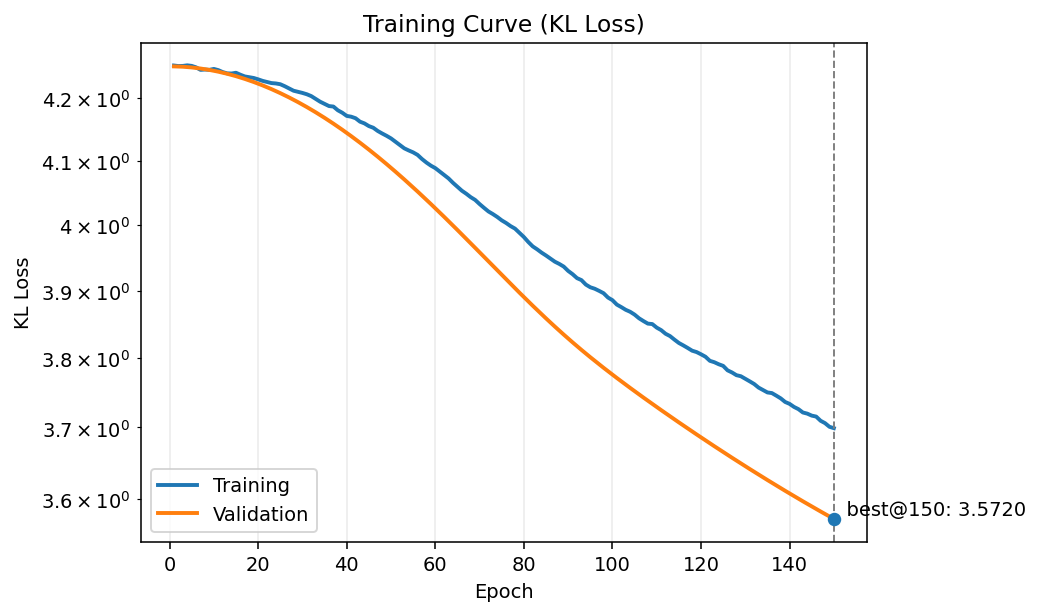

[saved] ./training_curve_kl.png


In [2]:
# ================= 绘图：训练/验证曲线（自动兼容张量/标量/列表） =================
import numpy as np
import torch
import matplotlib.pyplot as plt
from typing import Sequence, Any

def _to_1d_list(x: Any):
    """
    把 list/tuple/np.ndarray/torch.Tensor → 纯 Python list[float]
    自动 .cpu().item()，自动展平。
    """
    if x is None:
        return None
    if isinstance(x, torch.Tensor):
        if x.ndim == 0:
            return [float(x.detach().cpu().item())]
        return [float(t.detach().cpu().item()) for t in x.reshape(-1)]
    if isinstance(x, np.ndarray):
        return [float(v) for v in x.reshape(-1)]
    if isinstance(x, (list, tuple)):
        out = []
        for v in x:
            if isinstance(v, torch.Tensor):
                out.append(float(v.detach().cpu().item()))
            elif isinstance(v, (np.ndarray, list, tuple)):
                out.extend(_to_1d_list(v))
            else:
                out.append(float(v))
        return out
    # 单个标量
    try:
        return [float(x)]
    except Exception:
        return None

def _moving_average(y: Sequence[float], k: int):
    if y is None or len(y) == 0 or k <= 1:
        return y
    k = min(k, len(y))
    pad = k // 2
    y_pad = np.pad(np.asarray(y, dtype=float), (pad, pad), mode='edge')
    kernel = np.ones(k, dtype=float) / k
    return np.convolve(y_pad, kernel, mode='valid').tolist()

def plot_train_curves(loss_train, loss_eval, *,
                      title="Training Curve",
                      ylabel="Loss",
                      smooth=0,         # 平滑窗口（奇数，0/1 表示不平滑）
                      logy=True,        # y 轴取对数
                      savepath="./training_curve.png"):
    lt = _to_1d_list(loss_train) or []
    lv = _to_1d_list(loss_eval)  or []
    # 截齐长度（有些日志 eval 少于 train）
    n = min(len(lt), len(lv)) if lv else len(lt)
    x = list(range(1, n + 1))
    lt = lt[:n]
    if lv: lv = lv[:n]

    lt_plot = _moving_average(lt, smooth) if smooth and smooth > 1 else lt
    lv_plot = _moving_average(lv, smooth) if lv and smooth and smooth > 1 else lv

    plt.figure(figsize=(7.5, 4.5), dpi=140)
    plt.plot(x, lt_plot, label="Training", linewidth=2)
    if lv_plot:
        plt.plot(x, lv_plot, label="Validation", linewidth=2)

        # 标注最佳 epoch（取验证集最小值）
        best_idx = int(np.argmin(lv))  # 原始未平滑上的最佳
        best_x = best_idx + 1
        best_y = lv[best_idx]
        plt.axvline(best_x, color='gray', linestyle='--', linewidth=1)
        plt.scatter([best_x], [best_y], s=35, zorder=5)
        plt.text(best_x, best_y, f"  best@{best_x}: {best_y:.4f}", va='bottom', fontsize=10)

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    if logy:
        plt.yscale("log")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.savefig(savepath)
    plt.show()
    print(f"[saved] {savepath}")

# ====== 从 checkpoint 里取出曲线并绘图 ======
loss_all = a.get("loss_all", {})
# 兼容你之前的结构：a['loss_all']['train_loss'] / ['dev_loss']
train_curve = loss_all.get("train_loss", None)
dev_curve   = loss_all.get("dev_loss",   None)

print("Final dev loss:", (_to_1d_list(dev_curve) or [None])[-1])

# 主图：KL loss 曲线（对数坐标，平滑窗口=3 可改 0/1 表示不平滑）
plot_train_curves(train_curve, dev_curve,
                  title="Training Curve (KL Loss)",
                  ylabel="KL Loss",
                  smooth=3,
                  logy=True,
                  savepath="./training_curve_kl.png")

# 若 ckpt 里还有其它可选曲线（可选：学习率、准确率等），也尝试绘图
# 假设：loss_all 可能包含 'lrs' / 'train_acc' / 'dev_acc'
lrs = loss_all.get("lrs", None)
if lrs is not None:
    plot_train_curves(lrs, None,
                      title="Learning Rate (per epoch)",
                      ylabel="LR",
                      smooth=1,
                      logy=False,
                      savepath="./training_curve_lr.png")

train_acc = loss_all.get("train_acc", None)
dev_acc   = loss_all.get("dev_acc", None)
if train_acc is not None or dev_acc is not None:
    plot_train_curves(train_acc, dev_acc,
                      title="Accuracy Curve",
                      ylabel="Accuracy",
                      smooth=3,
                      logy=False,
                      savepath="./training_curve_acc.png")
